# Integradores RK y paso de tiempo adaptativo

En este notebook vamos a:

- Usar los integradores internos del simulador (`RK1`, `RK2`, `RK4`)
  sobre una ecuación diferencial muy simple.
- Comparar la precisión de cada integrador para distintos pasos de tiempo `dt`.
- Implementar un ejemplo de paso de tiempo **adaptativo** basado en estimar
  el error local.

> Importante:
> - Aquí NO modificamos el modelo RMS del VSC.
> - Solo usamos los integradores del proyecto en una ecuación de prueba.
> - El esquema adaptativo de este notebook es ilustrativo; el simulador RMS
>   tiene su propio timestepper integrado en el solver.


In [1]:
import matplotlib.pyplot as plt

from vscsim.solver.integrator_rk import (
    RK1Integrator,
    RK2Integrator,
    RK4Integrator,
)


## Ecuación de prueba

Usaremos la ecuación diferencial escalar:

\begin{align}
\frac{dx}{dt} = -x, \quad x(0) = 1
\end{align}

La solución analítica es:

\begin{align}
x(t) = e^{-t}
\end{align}

Esto nos permite comparar fácilmente la precisión de los integradores
para distintos pasos `dt`.


In [2]:
def deriv_exp_decay(state, context):
    return {"x": -state["x"]}

def exact_solution(t):
    return 2.718281828459045 ** (-t)

In [3]:
def integrate_ivp(integrator, t_end, dt):
    t = 0.0
    state = {"x": 1.0}
    ts = [t]
    xs = [state["x"]]

    while t < t_end:
        dt_step = min(dt, t_end - t)
        context = {"t": t}

        state = integrator.step(deriv_exp_decay, state, dt_step, context)

        t += dt_step
        ts.append(t)
        xs.append(state["x"])

    return ts, xs


In [4]:
rk1 = RK1Integrator()
rk2 = RK2Integrator()
rk4 = RK4Integrator()

t_end = 2.0
dt = 0.1


In [5]:
t_rk1, x_rk1 = integrate_ivp(rk1, t_end, dt)
t_rk2, x_rk2 = integrate_ivp(rk2, t_end, dt)
t_rk4, x_rk4 = integrate_ivp(rk4, t_end, dt)

t_exact = [i * 0.01 for i in range(int(t_end / 0.01) + 1)]
x_exact = [exact_solution(t) for t in t_exact]


## Ejemplo de paso de tiempo adaptativo

Ahora vamos a construir un ejemplo **ilustrativo** de dt adaptativo
para la misma ecuación:

- Usaremos **Euler explícito (RK1)** como integrador base.
- Para cada paso:
  - Calculamos una solución con paso `dt`.
  - Calculamos otra solución con dos pasos de `dt/2`.
  - Estimamos el error local como la diferencia entre ambas.
  - Si el error es mayor que una tolerancia, reducimos `dt`.
  - Si el error es mucho más pequeño, podemos aumentar `dt`.

Este esquema es una idea general; el simulador RMS tiene su propia
implementación de timestepper integrada en el solver.


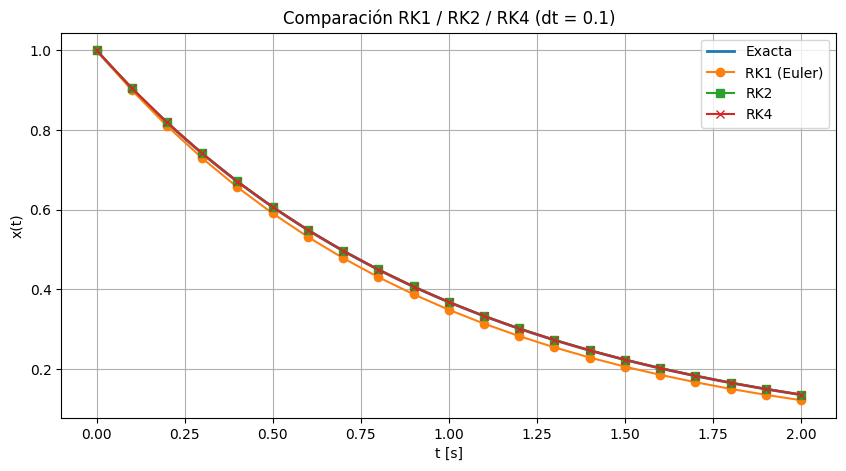

In [6]:
plt.figure(figsize=(10,5))

plt.plot(t_exact, x_exact, label="Exacta", linewidth=2)
plt.plot(t_rk1, x_rk1, "o-", label="RK1 (Euler)")
plt.plot(t_rk2, x_rk2, "s-", label="RK2")
plt.plot(t_rk4, x_rk4, "x-", label="RK4")

plt.xlabel("t [s]")
plt.ylabel("x(t)")
plt.title(f"Comparación RK1 / RK2 / RK4 (dt = {dt})")
plt.grid(True)
plt.legend()
plt.show()


## Resumen

En este notebook hemos:

- Reutilizado los integradores internos `RK1`, `RK2`, `RK4` del simulador
  sobre una ecuación de prueba muy simple.
- Comparado sus errores globales para distintos `dt`, observando el efecto
  del orden del método.
- Construido un ejemplo didáctico de paso de tiempo adaptativo basado en
  estimar el error local comparando:
  - un paso de tamaño `dt`, y
  - dos pasos de tamaño `dt/2`.

Este tipo de ideas son las que se usan internamente en el solver RMS con
su propio timestepper (`AdaptiveTimestepper`) para gestionar `dt` de
forma robusta en el modelo completo del VSC.
